In [1]:
# %%
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi/2, 0])

cfg = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

In [5]:
def take_time_sign(grandchild):
    """
    Извлекает слово после последнего подчеркивания из поля 'name' каждого внука.
    Возвращает список этих слов.
    """
    
    name = grandchild['name']
    match = re.search(r'_([^_]+)$', name)
    if match.group(1) == 'forward':
        return 1
    elif match.group(1) == 'backward':
        return -1
    else:
        raise ValueError(f"Неизвестный знак времени: {match}")

# take_time_sign(grandchildren[1])

# %%

In [ ]:
def draw_quad(state, time_sign,control, control_dot=0, N = 10, max_dt=0.1):
    quad_poses = [state]

    time = np.linspace(0, max_dt, N+1)
    for i in range(1,N+1):
        quad_poses.append(pendulum.quad_step(quad_poses[-1], control, 0, time_sign*time[i]))
        
    return np.array(quad_poses)

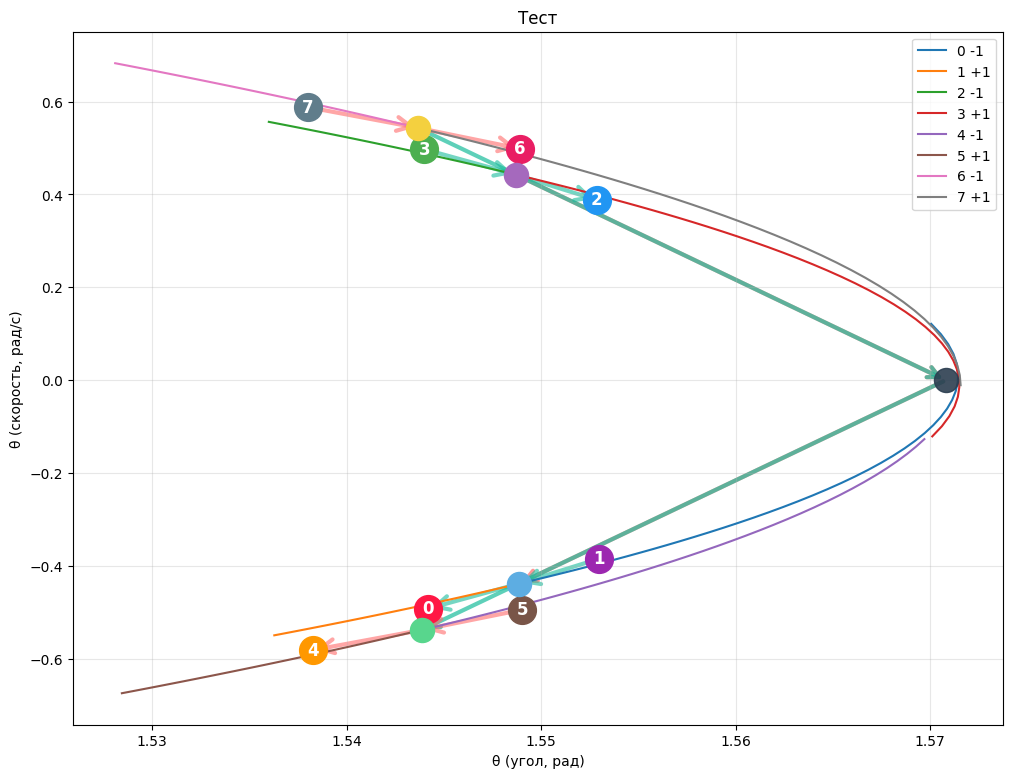

In [66]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")






dts = [0.005, 0.001, 0.001, 0.005, 0.003, 0.001, 0.001, 0.004]
for i in range(len(children)):
    poses_1 = draw_quad(state=children[i]['position'], time_sign=-1, control=children[i]['control'], N=50, max_dt=dts[2*i])
    poses_2 = draw_quad(state=children[i]['position'], time_sign=+1, control=children[i]['control'], N=50, max_dt=dts[2*i+1])
    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{2*i} -1')
    plt.plot(poses_2[:, 0], poses_2[:, 1], label=f'{2*i+1} +1')
plt.legend()


In [ ]:
def draw_rk(pendulumstate, time_sign, control, N = 50, total_dt=0.01):
    poses = [state]

    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, time_sign*total_dt/N*i))

    return np.array(poses)

In [197]:
init_position = np.array([np.pi/2, 0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

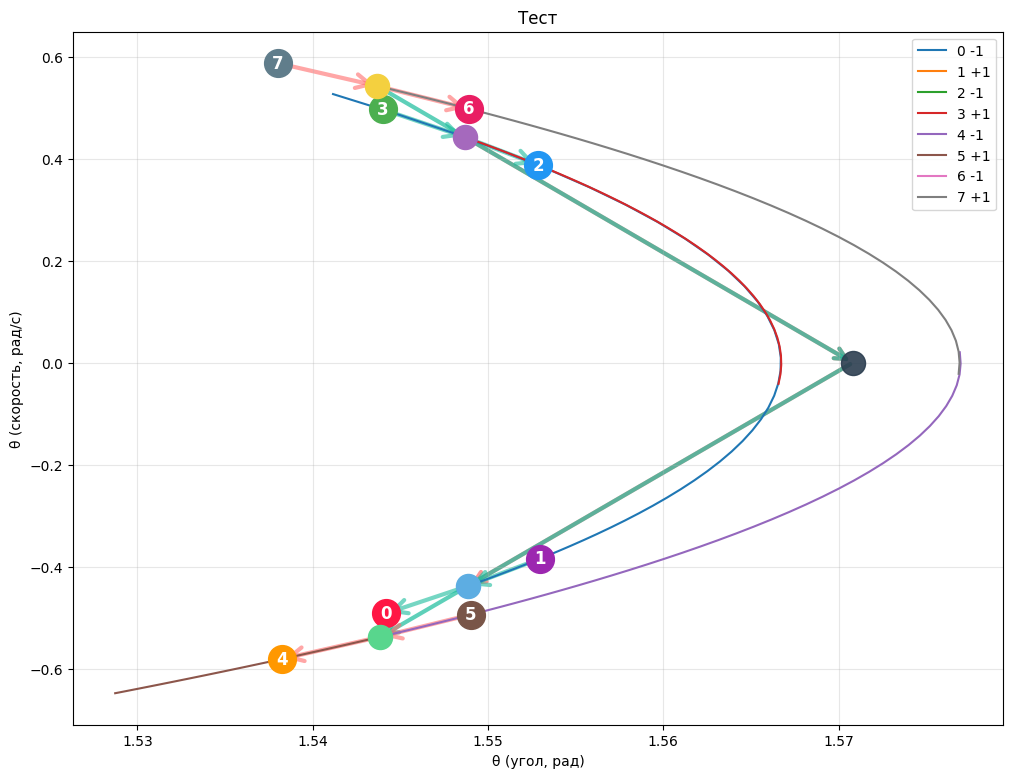

In [198]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")



dts = [0.007, 0.00, 0.00, 0.0035, 0.005, 0.001, 0.00, 0.005]
for i in range(len(children)):
    poses_1 = draw_rk(state=children[i]['position'], time_sign=-1, control=-children[i]['control'], total_dt=dts[2*i])
    poses_2 = draw_rk(state=children[i]['position'], time_sign=+1, control=-children[i]['control'], total_dt=dts[2*i+1])
    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{2*i} -1')
    plt.plot(poses_2[:, 0], poses_2[:, 1], label=f'{2*i+1} +1')
plt.legend()


In [ ]:
      gc_0  gc_1  gc_2  gc_3  gc_4  gc_5  gc_6  gc_7
gc_0     0     1    -1     1    -1     1     1     1
gc_1     1     0    -1     1     1     1    -1    -1
gc_2    -1    -1     0     1    -1    -1     1     1
gc_3     1     1     1     0     1     1     1    -1
gc_4    -1     1    -1     1     0     1    -1     1
gc_5     1     1    -1     1     1     0    -1     1
gc_6     1    -1     1     1    -1    -1     0     1
gc_7     1    -1     1    -1     1     1     1     0
gc_0 и gc_2 пересекутся!
gc_0 и gc_4 пересекутся!
gc_1 и gc_2 пересекутся!
gc_1 и gc_6 пересекутся!
gc_1 и gc_7 пересекутся!
gc_2 и gc_4 пересекутся!
gc_2 и gc_5 пересекутся!
gc_3 и gc_7 пересекутся!
gc_4 и gc_6 пересекутся!
gc_5 и gc_6 пересекутся!

In [165]:
def compute_phase_acceleration_table(grandchildren, pendulum, show=False):
    """
    Анализирует фазовое ускорение внуков через третью производную маятника.
    
    Фазовое ускорение = [θ̈, θ⃛] показывает, как меняется скорость сближения/расхождения.
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'name'
        pendulum: объект маятника
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица знаков вторых производных расстояний
    """
    import numpy as np
    import pandas as pd
    import re
    
    n = len(grandchildren)
    signs_table = np.zeros((n, n), dtype=int)
    
    # Вычисляем фазовые ускорения всех внуков
    phase_accelerations = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # Определяем направление времени
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        if match and match.group(1) == 'forward':
            time_sign = 1
        elif match and match.group(1) == 'backward':
            time_sign = -1
        else:
            time_sign = gc.get('time_sign', 1)
        
        # Получаем все производные
        _, theta_ddot, theta_dddot = pendulum.get_all_derivatives(pos, control)
        
        # Фазовое ускорение = [θ̈, θ⃛] с учетом направления времени
        phase_accel = time_sign * np.array([theta_ddot, theta_dddot])
        phase_accelerations.append(phase_accel)
    
    # Также вычисляем фазовые скорости для полного анализа
    phase_velocities = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        time_sign = 1 if (match and match.group(1) == 'forward') else -1
        
        _, theta_ddot, _ = pendulum.get_all_derivatives(pos, control)
        phase_vel = time_sign * np.array([pos[1], theta_ddot])
        phase_velocities.append(phase_vel)
    
    # Анализируем вторую производную расстояния для всех пар
    for i in range(n):
        for j in range(n):
            if i == j:
                signs_table[i, j] = 0
            else:
                # Позиции, скорости и ускорения
                r1 = grandchildren[i]['position']
                r2 = grandchildren[j]['position']
                v1 = phase_velocities[i]
                v2 = phase_velocities[j]
                a1 = phase_accelerations[i]
                a2 = phase_accelerations[j]
                
                # Векторы разности
                r_diff = r1 - r2
                v_diff = v1 - v2
                a_diff = a1 - a2
                
                # Текущее расстояние
                distance = np.linalg.norm(r_diff)
                
                if distance < 1e-10:
                    signs_table[i, j] = 0
                else:
                    # Первая производная расстояния
                    d_dist_dt = np.dot(r_diff, v_diff) / distance
                    
                    # Вторая производная расстояния (через ускорение)
                    # d²/dt²|r₁-r₂| = [(r₁-r₂)·(a₁-a₂) + |v₁-v₂|²]/|r₁-r₂| - [(r₁-r₂)·(v₁-v₂)]²/|r₁-r₂|³
                    
                    numerator = (np.dot(r_diff, a_diff) + 
                                np.dot(v_diff, v_diff) - 
                                (d_dist_dt**2))
                    
                    d2_dist_dt2 = numerator / distance
                    
                    # Классификация по второй производной
                    if d2_dist_dt2 < -1e-6:
                        signs_table[i, j] = -1  # Ускоренное сближение
                    elif d2_dist_dt2 > 1e-6:
                        signs_table[i, j] = 1   # Ускоренное расхождение  
                    else:
                        signs_table[i, j] = 0   # Постоянная скорость изменения расстояния
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(signs_table,
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("🚀 Таблица знаков ВТОРЫХ производных расстояний (фазовое ускорение):")
        print("   -1: ускоренное сближение ⇇")
        print("    0: равномерное изменение ●")
        print("   +1: ускоренное расхождение ⇉")
        print()
        print(df)
    
    return df

In [173]:
def compute_distance_table(grandchildren, show=False):
    """
    Составляет таблицу расстояний между всеми парами внуков в фазовом пространстве.
    
    Args:
        grandchildren: список внуков с полями 'position'
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица евклидовых расстояний |r_i - r_j|
    """
    import numpy as np
    import pandas as pd
    
    n = len(grandchildren)
    distance_table = np.zeros((n, n))
    
    # Вычисляем расстояния для всех пар
    for i in range(n):
        for j in range(n):
            if i == j:
                distance_table[i, j] = 0.0
            else:
                # Позиции внуков в фазовом пространстве [theta, theta_dot]
                r1 = grandchildren[i]['position']
                r2 = grandchildren[j]['position']
                
                # Евклидово расстояние в фазовом пространстве
                distance = np.linalg.norm(r1 - r2)
                distance_table[i, j] = distance
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(distance_table, 
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("📏 Таблица расстояний |r_i - r_j| в фазовом пространстве:")
        print("   Евклидово расстояние между позициями [θ, θ̇]")
        print()
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Статистика (исключаем диагональ)
        upper_triangle = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
        distances = upper_triangle.stack().values
        
        print(f"\nСтатистика расстояний:")
        print(f"  Минимальное расстояние: {distances.min():.6f}")
        print(f"  Максимальное расстояние: {distances.max():.6f}")
        print(f"  Среднее расстояние: {distances.mean():.6f}")
        print(f"  Медианное расстояние: {np.median(distances):.6f}")
        
        # Гистограмма расстояний
        print(f"\nРаспределение расстояний:")
        bins = [0, 0.5, 1.0, 2.0, 5.0, float('inf')]
        labels = ['< 0.5', '0.5-1.0', '1.0-2.0', '2.0-5.0', '> 5.0']
        
        for i, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
            count = ((distances >= low) & (distances < high)).sum()
            print(f"  {labels[i]:8s}: {count:2d} пар")
    
    return df

In [200]:
# distances = compute_distance_table(grandchildren, show=True)
velocities = compute_distance_derivative_table(grandchildren, pendulum, show=True)  
# accelerations = compute_phase_acceleration_table(grandchildren, pendulum, show=True)


📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (оптимизированная):
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.0000  10.7556  -0.0803  10.8070 -1.0017 -3.4341  0.9051  9.8156
gc_1  10.7556   0.0000 -10.8088   0.0962  9.7550  1.0068 -9.8199 -0.8896
gc_2  -0.0803 -10.8088   0.0000  10.9319 -1.0840 -9.7978  0.9848  9.9493
gc_3  10.8070   0.0962  10.9319   0.0000  9.7975  1.1036 -1.8149 -0.9837
gc_4  -1.0017   9.7550  -1.0840   9.7975  0.0000  8.7649 -0.0988  8.8054
gc_5  -3.4341   1.0068  -9.7978   1.1036  8.7649  0.0000 -8.8081  0.1177
gc_6   0.9051  -9.8199   0.9848  -1.8149 -0.0988 -8.8081  0.0000  8.9808
gc_7   9.8156  -0.8896   9.9493  -0.9837  8.8054  0.1177  8.9808  0.0000

Статистика:
  Сближающихся пар: 12
  Стационарных пар: 0
  Расходящихся пар: 16
  Всего уникальных пар: 28
  Максимальная скорость сближения: -10.808788
  

In [240]:
def find_best_partners_for_each_grandchild(velocity_df, tree, pendulum, show=False):
    """
    Для каждого внука находит его лучшего партнера для пересечения.
    
    Args:
        velocity_df: DataFrame с производными расстояний
        tree: объект SporeTree с созданными детьми и внуками
        pendulum: объект маятника
        show: выводить результаты
        
    Returns:
        dict: {gc_index: best_partner_info} для каждого внука
    """
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    
    n = len(velocity_df)
    best_partners = {}
    
    if show:
        print(f"🔍 Ищем лучшего партнера для каждого из {n} внуков...")
        print()
    
    # Для каждого внука
    for gc_i in range(n):
        if show:
            print(f"👤 Внук gc_{gc_i}:")
        
        best_distance = float('inf')
        best_partner_info = None
        
        # Проверяем всех потенциальных партнеров
        for gc_j in range(n):
            if gc_i == gc_j:
                continue
                
            # Проверяем, сближаются ли они
            velocity = velocity_df.iloc[gc_i, gc_j]
            if velocity >= -1e-6:  # Не сближаются
                continue
            
            if show:
                print(f"  Тестируем партнера gc_{gc_j} (скорость сближения: {velocity:.6f})")
            
            def distance_function(dt_params):
                """Расстояние между парой при заданных dt."""
                try:
                    dt_i, dt_j = dt_params
                    
                    # Пересчитываем позиции внуков с новыми dt
                    modified_grandchildren = []
                    
                    for idx, original_gc in enumerate(tree.grandchildren):
                        gc = original_gc.copy()
                        
                        # Назначаем новые dt только для нужной пары
                        if idx == gc_i:
                            gc['dt'] = dt_i
                        elif idx == gc_j:
                            gc['dt'] = dt_j
                        
                        # Пересчитываем позицию внука от родителя
                        parent = tree.children[gc['parent_idx']]
                        parent_pos = parent['position']
                        
                        # Определяем направление времени
                        name = gc.get('name', '')
                        if 'forward' in name:
                            time_sign = 1
                        elif 'backward' in name:
                            time_sign = -1
                        else:
                            time_sign = 1
                        
                        # Новая позиция
                        new_position = pendulum.step(parent_pos, gc['control'], time_sign * gc['dt'])
                        gc['position'] = new_position
                        modified_grandchildren.append(gc)
                    
                    # Расстояние между парой
                    pos_i = modified_grandchildren[gc_i]['position']
                    pos_j = modified_grandchildren[gc_j]['position']
                    return np.linalg.norm(pos_i - pos_j)
                    
                except Exception:
                    return 1e6
            
            # Исходные dt
            original_dt_i = tree.grandchildren[gc_i]['dt']
            original_dt_j = tree.grandchildren[gc_j]['dt']
            
            x0 = [abs(original_dt_i), abs(original_dt_j)]
            bounds = [
                (0.001, 1.0),  # Простые границы
                (0.001, 1.0)
            ]
            
            # Оптимизируем
            try:
                result = minimize(
                    distance_function,
                    x0=x0,
                    bounds=bounds,
                    method='L-BFGS-B',
                    options={'ftol': 1e-9}
                )
                
                if show:
                    print(f"    Результат оптимизации: success={result.success}, distance={result.fun:.6f}")
                
                if result.success and result.fun < best_distance:
                    optimal_dt_i, optimal_dt_j = result.x
                    
                    # Проверяем "кривизну" траектории - поворот вектора скорости
                    trajectory_is_good = True
                    max_angle_deg = 0
                    
                    # Для каждого внука в паре проверяем поворот вектора скорости
                    for gc_idx, optimal_dt, original_dt in [(gc_i, optimal_dt_i, original_dt_i), 
                                                           (gc_j, optimal_dt_j, original_dt_j)]:
                        # Исходный вектор скорости
                        original_gc = tree.grandchildren[gc_idx]
                        parent = tree.children[original_gc['parent_idx']]
                        
                        # Определяем направление времени из имени внука
                        name = original_gc.get('name', '')
                        if 'forward' in name:
                            time_sign = 1
                        elif 'backward' in name:
                            time_sign = -1
                        else:
                            time_sign = 1
                        
                        # Исходная позиция внука (с минимальным dt)
                        original_pos = pendulum.step(parent['position'], original_gc['control'], 
                                                   time_sign * original_dt)
                        
                        # Новая позиция внука (с оптимальным dt)
                        optimal_pos = pendulum.step(parent['position'], original_gc['control'], 
                                                  time_sign * optimal_dt)
                        
                        # Векторы скорости в фазовом пространстве
                        _, theta_ddot_orig, _ = pendulum.get_all_derivatives(original_pos, original_gc['control'])
                        _, theta_ddot_opt, _ = pendulum.get_all_derivatives(optimal_pos, original_gc['control'])
                        
                        velocity_orig = time_sign * np.array([original_pos[1], theta_ddot_orig])
                        velocity_opt = time_sign * np.array([optimal_pos[1], theta_ddot_opt])
                        
                        # Угол между векторами скорости
                        norm_orig = np.linalg.norm(velocity_orig)
                        norm_opt = np.linalg.norm(velocity_opt)
                        
                        if norm_orig > 1e-10 and norm_opt > 1e-10:
                            cos_angle = np.dot(velocity_orig, velocity_opt) / (norm_orig * norm_opt)
                            cos_angle = np.clip(cos_angle, -1.0, 1.0)  # Защита от численных ошибок
                            angle_rad = np.arccos(cos_angle)
                            angle_deg = np.degrees(angle_rad)
                            
                            max_angle_deg = max(max_angle_deg, angle_deg)
                            
                            # Если поворот больше 90 градусов - плохая траектория
                            if angle_deg > 90:
                                trajectory_is_good = False
                    
                    if show:
                        print(f"    Проверка кривизны: макс. поворот = {max_angle_deg:.1f}°")
                    
                    if trajectory_is_good:
                        best_distance = result.fun
                        
                        best_partner_info = {
                            'partner': gc_j,
                            'initial_velocity': velocity,
                            'min_distance': best_distance,
                            'optimal_dt_self': optimal_dt_i,
                            'optimal_dt_partner': optimal_dt_j,
                            'original_dt_self': original_dt_i,
                            'original_dt_partner': original_dt_j,
                            'dt_change_self': optimal_dt_i / abs(original_dt_i),
                            'dt_change_partner': optimal_dt_j / abs(original_dt_j),
                            'max_velocity_turn_deg': max_angle_deg,
                            'iterations': result.nit
                        }
                        
                        if show:
                            print(f"    ✅ Новый лучший партнер! Расстояние: {best_distance:.6f}")
                            print(f"       dt: gc_{gc_i}={optimal_dt_i:.6f}, gc_{gc_j}={optimal_dt_j:.6f}")
                            if best_distance < 1e-6:
                                print(f"    🎯 ИДЕАЛЬНОЕ ПЕРЕСЕЧЕНИЕ!")
                    else:
                        if show:
                            print(f"    ❌ Траектория слишком кривая (поворот > 90°), отвергаем")
                elif show:
                    print(f"    Расстояние: {result.fun:.6f} (не лучше текущего {best_distance:.6f})")
                    
            except Exception as e:
                if show:
                    print(f"    ❌ Ошибка: {e}")
        
        # Сохраняем лучшего партнера для этого внука
        if best_partner_info:
            best_partners[gc_i] = best_partner_info
            if show:
                partner = best_partner_info['partner']
                dist = best_partner_info['min_distance']
                angle = best_partner_info['max_velocity_turn_deg']
                print(f"  🏆 Лучший партнер: gc_{partner}, расстояние: {dist:.6f}, поворот: {angle:.1f}°")
        else:
            if show:
                print(f"  😞 Нет подходящих партнеров")
        
        if show:
            print()
    
    # Итоговая сводка
    if show:
        print("📊 ИТОГОВАЯ СВОДКА:")
        if best_partners:
            for gc_i, info in best_partners.items():
                partner = info['partner']
                dist = info['min_distance']
                vel = info['initial_velocity']
                angle = info['max_velocity_turn_deg']
                print(f"  gc_{gc_i} → gc_{partner}: расст={dist:.6f}, скорость={vel:.6f}, поворот={angle:.1f}°")
            
            # Найдем глобально лучшую пару
            global_best = min(best_partners.items(), key=lambda x: x[1]['min_distance'])
            gc_i, info = global_best
            print(f"\n🥇 ГЛОБАЛЬНО ЛУЧШАЯ ПАРА: gc_{gc_i} ↔ gc_{info['partner']}")
            print(f"   Расстояние: {info['min_distance']:.6f}")
            print(f"   Нужные dt: {info['optimal_dt_self']:.6f}, {info['optimal_dt_partner']:.6f}")
            print(f"   Поворот вектора скорости: {info['max_velocity_turn_deg']:.1f}°")
        else:
            print("  😞 Нет подходящих пар для пересечений")
    
    return best_partners

In [241]:
# Анализируем скорости
velocity_df = compute_distance_derivative_table(grandchildren, pendulum, show=True)

# Находим лучшего партнера для каждого внука
best_partners = find_best_partners_for_each_grandchild(velocity_df, tree, pendulum, show=True)

# Анализируем результаты
for gc_i, info in best_partners.items():
    partner = info['partner']
    distance = info['min_distance']
    print(f"gc_{gc_i} лучше всего пересекается с gc_{partner} (расстояние: {distance:.6f})")

📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (оптимизированная):
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.0000  10.7556  -0.0803  10.8070 -1.0017 -3.4341  0.9051  9.8156
gc_1  10.7556   0.0000 -10.8088   0.0962  9.7550  1.0068 -9.8199 -0.8896
gc_2  -0.0803 -10.8088   0.0000  10.9319 -1.0840 -9.7978  0.9848  9.9493
gc_3  10.8070   0.0962  10.9319   0.0000  9.7975  1.1036 -1.8149 -0.9837
gc_4  -1.0017   9.7550  -1.0840   9.7975  0.0000  8.7649 -0.0988  8.8054
gc_5  -3.4341   1.0068  -9.7978   1.1036  8.7649  0.0000 -8.8081  0.1177
gc_6   0.9051  -9.8199   0.9848  -1.8149 -0.0988 -8.8081  0.0000  8.9808
gc_7   9.8156  -0.8896   9.9493  -0.9837  8.8054  0.1177  8.9808  0.0000

Статистика:
  Сближающихся пар: 12
  Стационарных пар: 0
  Расходящихся пар: 16
  Всего уникальных пар: 28
  Максимальная скорость сближения: -10.808788
  

In [ ]:
      gc_0  gc_1  gc_2  gc_3  gc_4  gc_5  gc_6  gc_7
gc_0     0     1    -1     1    -1     1     1     1
gc_1     1     0    -1     1     1     1    -1    -1
gc_2    -1    -1     0     1    -1    -1     1     1
gc_3     1     1     1     0     1     1     1    -1
gc_4    -1     1    -1     1     0     1    -1     1
gc_5     1     1    -1     1     1     0    -1     1
gc_6     1    -1     1     1    -1    -1     0     1
gc_7     1    -1     1    -1     1     1     1     0
gc_0 и gc_2 пересекутся!
gc_0 и gc_4 пересекутся!
gc_1 и gc_2 пересекутся!
gc_1 и gc_6 пересекутся!
gc_1 и gc_7 пересекутся!
gc_2 и gc_4 пересекутся!
gc_2 и gc_5 пересекутся!
gc_3 и gc_7 пересекутся!
gc_4 и gc_6 пересекутся!
gc_5 и gc_6 пересекутся!

In [199]:
def compute_distance_derivative_table(grandchildren, pendulum, show=False):
    """
    Составляет оптимизированную таблицу первых производных расстояний (только верхний треугольник).
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'name'
        pendulum: объект маятника для вычисления скоростей
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: симметричная таблица значений d/dt|r_i - r_j|
            Отрицательные: сближаются (чем меньше, тем быстрее)
            Положительные: расходятся (чем больше, тем быстрее)
    """
    import numpy as np
    import pandas as pd
    import re
    
    n = len(grandchildren)
    values_table = np.zeros((n, n))
    
    # Вычисляем скорости всех внуков с учетом направления времени
    velocities = []
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # Определяем направление времени из имени
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        if match and match.group(1) == 'forward':
            time_sign = 1
        elif match and match.group(1) == 'backward':
            time_sign = -1
        else:
            time_sign = gc.get('time_sign', 1)
        
        # Получаем ускорение от маятника
        _, theta_ddot, _ = pendulum.get_all_derivatives(pos, control)
        
        # Скорость в фазовом пространстве с учетом направления времени
        velocity_vector = time_sign * np.array([pos[1], theta_ddot])
        velocities.append(velocity_vector)
    
    # Заполняем только верхний треугольник (оптимизация в 2 раза)
    for i in range(n):
        for j in range(i+1, n):  # Только j > i
            # Позиции и скорости
            r1 = grandchildren[i]['position']
            r2 = grandchildren[j]['position']
            v1 = velocities[i]
            v2 = velocities[j]
            
            # Вектор между точками и разность скоростей
            r_diff = r1 - r2
            v_diff = v1 - v2
            
            # Текущее расстояние
            distance = np.linalg.norm(r_diff)
            
            if distance < 1e-10:
                derivative_value = 0.0
            else:
                # Производная расстояния: d/dt |r1 - r2| = (r1-r2)·(v1-v2) / |r1-r2|
                derivative_value = np.dot(r_diff, v_diff) / distance
            
            # Заполняем симметрично
            values_table[i, j] = derivative_value
            values_table[j, i] = derivative_value
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(values_table, 
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        print("📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j| (оптимизированная):")
        print("   < 0: сближаются (чем меньше, тем быстрее)")
        print("   = 0: стационарно") 
        print("   > 0: расходятся (чем больше, тем быстрее)")
        print()
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Дополнительная статистика (только верхний треугольник)
        upper_triangle = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
        valid_values = upper_triangle.stack().values
        
        negative_count = (valid_values < -1e-6).sum()
        zero_count = ((valid_values >= -1e-6) & (valid_values <= 1e-6)).sum()
        positive_count = (valid_values > 1e-6).sum()
        
        print(f"\nСтатистика:")
        print(f"  Сближающихся пар: {negative_count}")
        print(f"  Стационарных пар: {zero_count}")
        print(f"  Расходящихся пар: {positive_count}")
        print(f"  Всего уникальных пар: {len(valid_values)}")
        
        if negative_count > 0:
            min_val = valid_values[valid_values < -1e-6].min()
            print(f"  Максимальная скорость сближения: {min_val:.6f}")
        if positive_count > 0:
            max_val = valid_values[valid_values > 1e-6].max()
            print(f"  Максимальная скорость расхождения: {max_val:.6f}")
    
    return df

In [171]:
def compute_phase_acceleration_table(grandchildren, pendulum, show=False):
    """
    Анализирует фазовое ускорение внуков через вторую производную расстояний.
    
    Args:
        grandchildren: список внуков с полями 'position', 'control', 'name'
        pendulum: объект маятника
        show: выводить таблицу
        
    Returns:
        pandas.DataFrame: таблица значений d²/dt²|r_i - r_j|
            Отрицательные: ускоренное сближение 
            Положительные: ускоренное расхождение
    """
    import numpy as np
    import pandas as pd
    import re
    
    n = len(grandchildren)
    values_table = np.zeros((n, n))
    
    # Вычисляем фазовые ускорения всех внуков
    phase_accelerations = []
    phase_velocities = []
    
    for i, gc in enumerate(grandchildren):
        pos = gc['position']
        control = gc['control']
        
        # Определяем направление времени
        name = gc.get('name', '')
        match = re.search(r'_([^_]+)$', name)
        if match and match.group(1) == 'forward':
            time_sign = 1
        elif match and match.group(1) == 'backward':
            time_sign = -1
        else:
            time_sign = gc.get('time_sign', 1)
        
        # Получаем все производные
        _, theta_ddot, theta_dddot = pendulum.get_all_derivatives(pos, control)
        
        # Фазовая скорость и ускорение с учетом направления времени
        phase_vel = time_sign * np.array([pos[1], theta_ddot])
        phase_accel = time_sign * np.array([theta_ddot, theta_dddot])
        
        phase_velocities.append(phase_vel)
        phase_accelerations.append(phase_accel)
    
    # Анализируем вторую производную расстояния для всех пар
    for i in range(n):
        for j in range(n):
            if i == j:
                values_table[i, j] = 0.0
            else:
                # Позиции, скорости и ускорения
                r1 = grandchildren[i]['position']
                r2 = grandchildren[j]['position']
                v1 = phase_velocities[i]
                v2 = phase_velocities[j]
                a1 = phase_accelerations[i]
                a2 = phase_accelerations[j]
                
                # Векторы разности
                r_diff = r1 - r2
                v_diff = v1 - v2
                a_diff = a1 - a2
                
                # Текущее расстояние
                distance = np.linalg.norm(r_diff)
                
                if distance < 1e-10:
                    values_table[i, j] = 0.0
                else:
                    # Первая производная расстояния
                    d_dist_dt = np.dot(r_diff, v_diff) / distance
                    
                    # Вторая производная расстояния
                    # d²/dt²|r₁-r₂| = [(r₁-r₂)·(a₁-a₂) + |v₁-v₂|² - (d/dt|r₁-r₂|)²] / |r₁-r₂|
                    
                    numerator = (np.dot(r_diff, a_diff) + 
                                np.dot(v_diff, v_diff) - 
                                (d_dist_dt**2))
                    
                    d2_dist_dt2 = numerator / distance
                    values_table[i, j] = d2_dist_dt2
    
    # Создаем pandas DataFrame
    df = pd.DataFrame(values_table,
                     index=[f"gc_{i}" for i in range(n)],
                     columns=[f"gc_{i}" for i in range(n)])
    
    if show:
        
        # Форматируем вывод с 4 знаками после запятой
        with pd.option_context('display.precision', 4):
            print(df)
        
        # Дополнительная статистика
        print(f"\nСтатистика:")
        negative_count = (df < -1e-6).sum().sum()
        zero_count = ((df >= -1e-6) & (df <= 1e-6)).sum().sum() - n  # исключаем диагональ
        positive_count = (df > 1e-6).sum().sum()
        
        print(f"  Ускоренно сближающихся пар: {negative_count}")
        print(f"  Равномерно изменяющихся пар: {zero_count}")
        print(f"  Ускоренно расходящихся пар: {positive_count}")
        
        if negative_count > 0:
            min_val = df[df < -1e-6].min().min()
            print(f"  Максимальное ускорение сближения: {min_val:.6f}")
        if positive_count > 0:
            max_val = df[df > 1e-6].max().max()
            print(f"  Максимальное ускорение расхождения: {max_val:.6f}")
    
    return df

In [168]:
df = compute_distance_derivative_table(grandchildren, pendulum, show=True)

# Найти всех, кто сближается с gc_0
converging_with_0 = df.loc['gc_0'][df.loc['gc_0'] == -1].index.tolist()

# Или найти все сближающиеся пары
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if df.iloc[i, j] == -1:
            print(f"gc_{i} и gc_{j} пересекутся!")

📊 Таблица ПЕРВЫХ производных расстояний d/dt|r_i - r_j|:
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3    gc_4    gc_5    gc_6    gc_7
gc_0   0.0000  10.7552  -0.0724  10.8056 -0.9987  9.7449  0.9128  9.8129
gc_1  10.7552   0.0000 -10.8093   0.1040  9.7560  1.0091 -9.8215 -0.8820
gc_2  -0.0724 -10.8093   0.0000  10.9315 -1.0744 -9.7974  0.9851  9.9483
gc_3  10.8056   0.1040  10.9315   0.0000  9.7968  1.1133  9.9457 -0.9828
gc_4  -0.9987   9.7560  -1.0744   9.7968  0.0000  8.7643 -0.0894  8.8034
gc_5   9.7449   1.0091  -9.7974   1.1133  8.7643  0.0000 -8.8089  0.1271
gc_6   0.9128  -9.8215   0.9851   9.9457 -0.0894 -8.8089  0.0000  8.9802
gc_7   9.8129  -0.8820   9.9483  -0.9828  8.8034  0.1271  8.9802  0.0000

Статистика:
  Сближающихся пар: 20
  Стационарных пар: 0
  Расходящихся пар: 36
  Максимальная скорость сближения: -10.809284
  Максимальная скорость расхождения: 10.931463


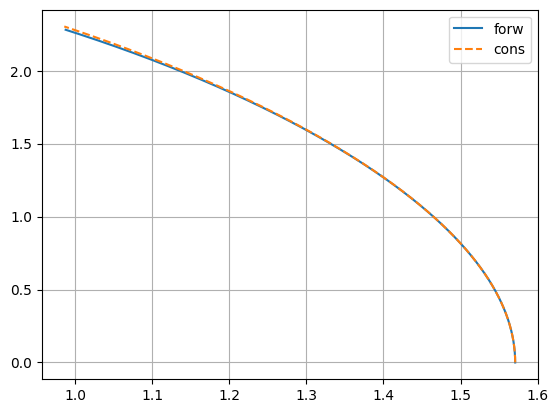

In [43]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0,
)

init_state = np.array([np.pi/2, 0])
dt = 0.0001
N = 5000
poses_cons = [init_state]
poses_forw = [init_state]
for i in range(N):
    poses_cons.append(pendulum.step(poses_cons[-1], 1, -dt))
    poses_forw.append(pendulum.step(poses_forw[ 0], 1, -i*dt))

poses_cons = np.array(poses_cons)
poses_forw = np.array(poses_forw)


plt.plot(poses_forw[:, 0], poses_forw[:, 1], label='forw')
plt.plot(poses_cons[:, 0], poses_cons[:, 1], label='cons', linestyle='--')
plt.legend()
plt.grid()
